## Introduction



This tutorial illustrates the spectra computation for standard and pure B modes. We will only use
the `HEALPIX` pixellisation to pass through the different steps of generation.

The `HEALPIX` survey mask is a disk centered on longitude 30° and latitude 50° with a radius of 25
radians. The `nside` value is set to 512 for this tutorial to reduce computation time.



## Preamble



`matplotlib` magic



In [1]:
%matplotlib inline

Versions used for this tutorial



In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import healpy as hp
import pspy
print("     Numpy :", np.__version__)
print("Matplotlib :", mpl.__version__)
print("    healpy :", hp.__version__)
print("      pspy :", pspy.__version__)

     Numpy : 1.18.0
Matplotlib : 3.1.2
    healpy : 1.13.0
      pspy : 1.2.0+4.gcb26dc1


Get default data dir from `pspy` and set Planck colormap as default



In [3]:
from pixell import colorize
colorize.mpl_setdefault("planck")

## Generation of the templates, mask and apodisation type



We start by specifying the `HEALPIX` survey parameters namely longitude, latitude and patch size. The
`nside` value is set to 512.



In [4]:
lon, lat = 30, 50
radius = 25
nside = 512

Given the `nside` value, we can set the $\ell$<sub>max</sub> value



In [5]:
lmax = 3 * nside - 1

For this example, we will make use of 3 components : Temperature (spin 0) and polarisation Q and U
(spin 2)



In [6]:
ncomp = 3

Given the parameters, we can generate the `HEALPIX` template as follow



In [7]:
from pspy import so_map
template = so_map.healpix_template(ncomp, nside)

We also define the binary template for the window function pixels



In [8]:
binary = so_map.healpix_template(ncomp=1, nside=nside)
vec = hp.pixelfunc.ang2vec(lon, lat, lonlat=True)
disc = hp.query_disc(nside, vec, radius=radius*np.pi/180)
binary.data[disc] = 1

## Generation of spectra



### Generate window



We then create an apodisation for the survey mask. We use a C1 apodisation with an apodisation size
of 5 degrees



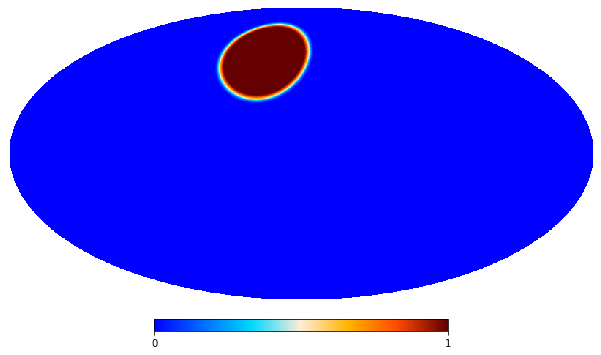

In [9]:
from pspy import so_window
window = so_window.create_apodization(binary, apo_type="C1", apo_radius_degree=5)
hp.mollview(window.data, title=None)

We can also have a look to the corresponding spin 1 and spin 2 window functions



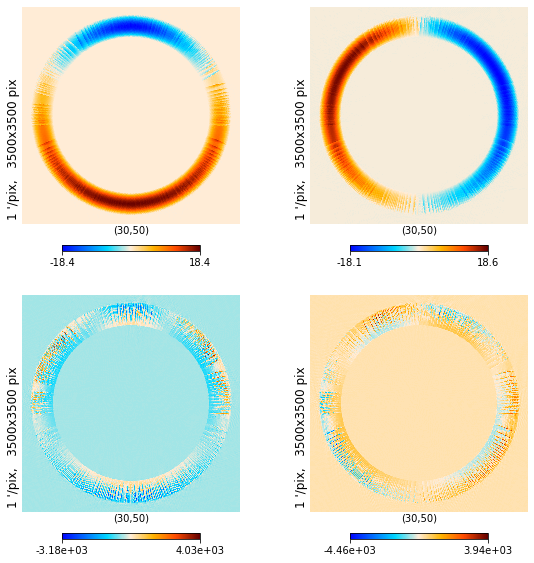

In [10]:
niter = 3
w1_plus, w1_minus, w2_plus, w2_minus = so_window.get_spinned_windows(window, lmax=lmax, niter=niter)
plt.figure(figsize=(8, 8))
kwargs = {"rot": (lon, lat, 0), "xsize": 3500, "reso": 1, "title": None}
hp.gnomview(w1_plus.data, **kwargs, sub=(2, 2, 1))
hp.gnomview(w1_minus.data, **kwargs, sub=(2, 2, 2))
hp.gnomview(w2_plus.data, **kwargs, sub=(2, 2, 3))
hp.gnomview(w2_minus.data, **kwargs, sub=(2, 2, 4))

### Binning file



We create a binning file with the following format : lmin, lmax, lmean



In [11]:
import os
output_dir = "/tmp/tutorial_purebb"
os.makedirs(output_dir, exist_ok=True)
binning_file = os.path.join(output_dir, "binning.dat")
from pspy import pspy_utils
pspy_utils.create_binning_file(bin_size=50, n_bins=300, file_name=binning_file)

### Compute mode coupling matrix



For spin 0 and 2 the window need to be a tuple made of two objects: the window used for spin 0 and the
one used for spin 2



In [12]:
window_tuple = (window, window)

The windows (for `spin0` and `spin2`) are going to couple mode together, we compute a mode coupling
matrix in order to undo this effect given the binning file. We do it for both calculations *i.e.*
standard and pure B mode



In [13]:
from pspy import so_mcm
print("computing standard mode coupling matrix")
mbb_inv, Bbl = so_mcm.mcm_and_bbl_spin0and2(window_tuple,
                                            binning_file,
                                            lmax=lmax,
                                            niter=niter,
                                            type="Cl")

print("computing pure mode coupling matrix")
mbb_inv_pure, Bbl_pure = so_mcm.mcm_and_bbl_spin0and2(window_tuple,
                                                      binning_file,
                                                      lmax=lmax,
                                                      niter=niter,
                                                      type="Cl",
                                                      pure=True)

computing standard mode coupling matrix
computing pure mode coupling matrix


### Generation of ΛCDM power spectra



We first have to compute $C_\ell$ data using a cosmology code such as [CAMB](https://camb.readthedocs.io/en/latest/) and we need to install it
since this is not a prerequisite of `pspy`. We can do it within this notebook by executing the
following command



In [14]:
%pip install -U camb

Requirement already up-to-date: camb in /home/garrido/Workdir/CMB/development/pspy/pyenv/lib/python3.8/site-packages (1.1.0)
Note: you may need to restart the kernel to use updated packages.


To make sure everything goes well, we can import `CAMB` and check its version



In [15]:
import camb
print("CAMB version:", camb.__version__)

CAMB version: 1.1.0


Now that `CAMB` is properly installed, we will produce $C_\ell$ data from $\ell$<sub>min</sub>=2 to
$\ell$<sub>max</sub>=10<sup>4</sup> for the following set of $\Lambda$CDM parameters



In [16]:
ellmin, ellmax = 2, 10**4
ell = np.arange(ellmin, ellmax)
cosmo_params = {
    "H0": 67.5,
    "As": 1e-10*np.exp(3.044),
    "ombh2": 0.02237,
    "omch2": 0.1200,
    "ns": 0.9649,
    "Alens": 1.0,
    "tau": 0.0544
}
pars = camb.set_params(**cosmo_params)
pars.set_for_lmax(ellmax, lens_potential_accuracy=1)
results = camb.get_results(pars)
powers = results.get_cmb_power_spectra(pars, CMB_unit="muK")

We finally have to write $C_\ell$ into a file to feed the `so_map.synfast` function for both
pixellisation templates



In [17]:
cl_file = os.path.join(output_dir, "cl_camb.dat")
np.savetxt(cl_file,
           np.hstack([ell[:, np.newaxis], powers["total"][ellmin:ellmax]]))

## Running simulations



Given the parameters and data above, we will now simulate `n_sims` simulations to check for mean and
variance of BB spectrum. For illustrative purpose, we will only run 10 simulations (~ few minutes)
but for reasonable comparisons, you should increase this number to few tens of simulations.

We will do it for both calculations (standard and pure) and finally we will graphically compare
results

We first need to specify the order of the spectra to be used by `pspy` although only BB spectrum will
be used



In [18]:
spectra = ["TT", "TE", "TB", "ET", "BT", "EE", "EB", "BE", "BB"]

and we define a dictionnary of methods regarding the calculation type for B mode spectrum



In [19]:
from pspy import sph_tools
methods = {
    "standard": {"alm" : sph_tools.get_alms, "mbb": mbb_inv, "bb": []},
    "pure": {"alm": sph_tools.get_pure_alms, "mbb": mbb_inv_pure, "bb": []}
}

In [20]:
from pspy import so_spectra
n_sims = 10
for i in range(n_sims):
  cmb = template.synfast(cl_file)
  for k, v in methods.items():
    get_alm = v.get("alm")
    alm = get_alm(cmb, window_tuple, niter, lmax)
    ell, ps = so_spectra.get_spectra(alm, spectra=spectra)
    ellb, ps_dict = so_spectra.bin_spectra(ell,
                                           ps,
                                           binning_file,
                                           lmax,
                                           type="Cl",
                                           mbb_inv=v.get("mbb"),
                                           spectra=spectra)
    v["bb"] += [ps_dict["BB"]]

Let's plot the mean results against the theory value for BB spectrum



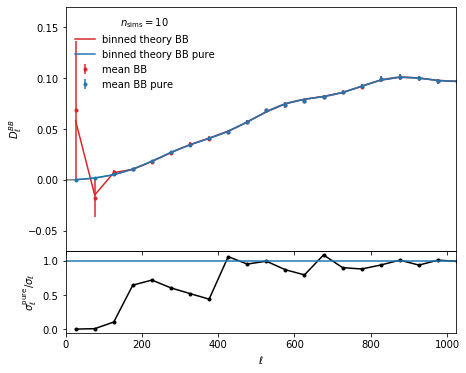

In [21]:
for k, v in methods.items():
    v["mean"] = np.mean(v.get("bb"), axis=0)
    v["std"] = np.std(v.get("bb"), axis=0)

from pspy import pspy_utils
ell_th, ps_theory = pspy_utils.ps_lensed_theory_to_dict(cl_file, output_type="Cl", lmax=lmax)
ps_theory_b = so_mcm.apply_Bbl(Bbl, ps_theory, spectra=spectra)
ps_theory_b_pure = so_mcm.apply_Bbl(Bbl_pure, ps_theory, spectra=spectra)

fac = ellb * (ellb + 1) / (2 * np.pi)
facth = ell_th * (ell_th + 1) / (2 * np.pi)

plt.figure(figsize=(7, 6))
grid = plt.GridSpec(4, 1, hspace=0, wspace=0)

main = plt.subplot(grid[:3], xticklabels=[], xlim=(0, 2*nside))
main.plot(ell_th[:lmax], ps_theory["BB"][:lmax] * facth[:lmax], color="grey")
main.errorbar(ellb, ps_theory_b["BB"] * fac, color="tab:red", label="binned theory BB")
main.errorbar(ellb, ps_theory_b_pure["BB"] * fac, color="tab:blue", label="binned theory BB pure")
main.errorbar(ellb, methods.get("standard").get("mean") * fac,
              methods.get("standard").get("std") * fac, fmt=".", color="tab:red", label="mean BB")
main.errorbar(ellb, methods.get("pure").get("mean") * fac,
             methods.get("pure").get("std") * fac, fmt=".", color="tab:blue", label="mean BB pure")
main.set(ylim=(-0.07, 0.17), ylabel=r"$D^{BB}_{\ell}$")
plt.legend(title=r"$n_{\rm sims}=%s$" % n_sims)

ratio = plt.subplot(grid[3], xlim=(0, 2*nside))
ratio.plot(ellb, methods.get("pure").get("std") / methods.get("standard").get("std"), ".-k")
ratio.set(ylabel=r"$\sigma^{\rm pure}_\ell/ \sigma_\ell$", xlabel=r"$\ell$");
ratio.axhline(1)